# Bechdel Test on Youtube Trailers 
Test for Observatoire des Images

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import _pickle as pickle
from PIL import Image
import os

import requests
import cv2

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

https://huggingface.co/spaces/fcakyon/zero-shot-video-classification

# Whisper

In [10]:
import whisper

model = whisper.load_model("base")
# result = model.transcribe("audio.mp3")
# print(result["text"])

100%|███████████████████████████████████████| 139M/139M [00:24<00:00, 5.96MiB/s]


# Scene segmentation with CLIP-X

In [24]:
from transformers import AutoProcessor, AutoModel

DEFAULT_MODEL = "microsoft/xclip-base-patch16-zero-shot"

VALID_ZEROSHOT_VIDEOCLASSIFICATION_MODELS = [
    "microsoft/xclip-base-patch32",
    "microsoft/xclip-base-patch16-zero-shot",
    "microsoft/xclip-base-patch16-kinetics-600",
    "microsoft/xclip-large-patch14ft/xclip-base-patch32-16-frames",
    "microsoft/xclip-large-patch14",
    "microsoft/xclip-base-patch16-hmdb-4-shot",
    "microsoft/xclip-base-patch16-16-frames",
    "microsoft/xclip-base-patch16-hmdb-2-shot",
    "microsoft/xclip-base-patch16-ucf-2-shot",
    "microsoft/xclip-base-patch16-ucf-8-shot",
    "microsoft/xclip-base-patch16",
    "microsoft/xclip-base-patch16-hmdb-8-shot",
    "microsoft/xclip-base-patch16-hmdb-16-shot",
    "microsoft/xclip-base-patch16-ucf-16-shot",
]

processor = AutoProcessor.from_pretrained(DEFAULT_MODEL)
model = AutoModel.from_pretrained(DEFAULT_MODEL)

In [ ]:
import bechdelai
from bechdelai.video.video import Video

video_path = "LES TUCHE 4 Bande Annonce Officielle (2021).mp4"
# video_path = "QUEST CE QUON A FAIT AU BON DIEU  Bande Annonce.mp4"

video = Video(path = video_path,max_seconds = None,fps = 1)

video.replay()

# Playground

In [95]:
import bechdelai
from bechdelai.video.video import Video

video_path = "LES TUCHE 4 Bande Annonce Officielle (2021).mp4"
# video_path = "QUEST CE QUON A FAIT AU BON DIEU  Bande Annonce.mp4"

video = Video(path = video_path,max_seconds = 30,fps = 2)

  0%|          | 0/246 [00:00<?, ?it/s]

Stopped after 30 seconds


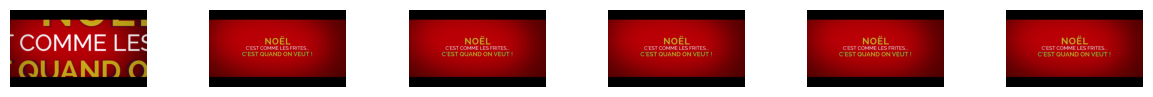

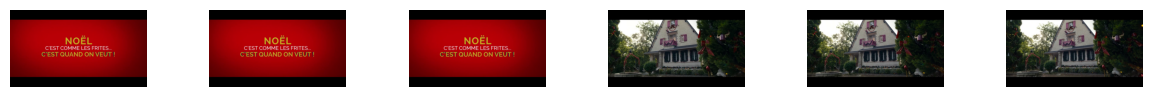

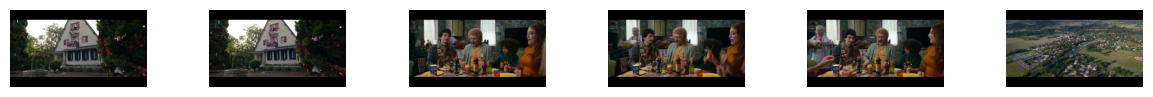

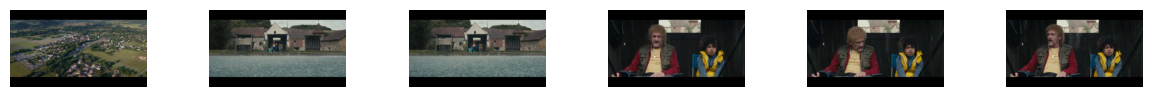

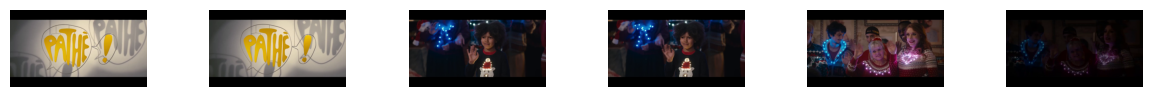

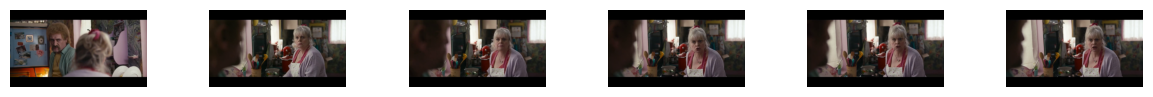

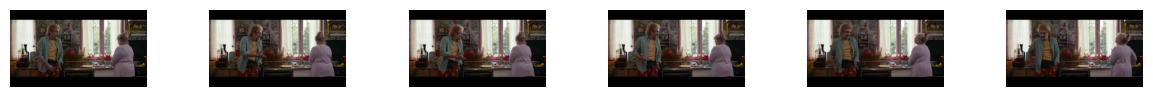

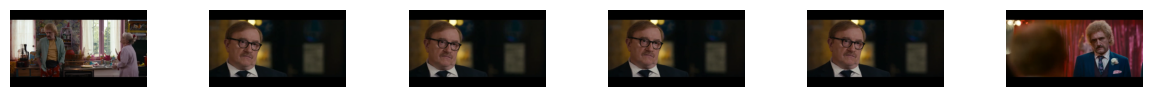

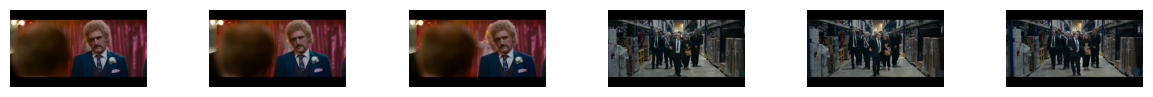

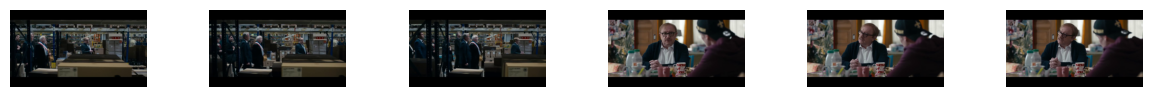

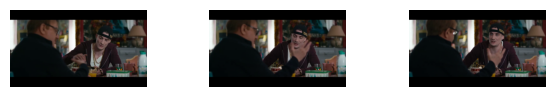

In [96]:
video.show_frames()

In [130]:
frames2 = np.stack([x.array for x in video.frames])
frames2.shape

(63, 720, 1280, 3)

In [180]:
from transformers import XCLIPProcessor, XCLIPModel

In [181]:
processor = XCLIPProcessor.from_pretrained(DEFAULT_MODEL)
model = XCLIPModel.from_pretrained(DEFAULT_MODEL)

In [119]:
from decord import VideoReader

def sample_frames_from_video_file(
    file_path: str, num_frames: int = 16, frame_sampling_rate=1
):
    videoreader = VideoReader(file_path)
    videoreader.seek(0)

    # sample frames
    start_idx = 0
    end_idx = num_frames * frame_sampling_rate - 1
    indices = np.linspace(start_idx, end_idx, num=num_frames, dtype=np.int64)
    frames = videoreader.get_batch(indices).asnumpy()

    return frames

In [125]:
frames = sample_frames_from_video_file(video_path,64)

In [126]:
frames.shape

(64, 720, 1280, 3)

In [131]:
labels = ["dialogue between two persons or more","action scene","introduction scene"]
inputs = processor(
        text=labels, videos=list(frames2)[:32], return_tensors="pt", padding=True
    )

In [129]:
# forward pass
with torch.no_grad():
    outputs = model(**inputs)

RuntimeError: The size of tensor a (64) must match the size of tensor b (32) at non-singleton dimension 1

In [124]:
probs = outputs.logits_per_video[0].softmax(dim=-1).cpu().numpy()
label_to_prob = {}
for ind, label in enumerate(labels):
    label_to_prob[label] = float(probs[ind])
    
label_to_prob

{'dialogue between two persons or more': 0.2105664610862732,
 'action scene': 0.24200576543807983,
 'introduction scene': 0.5474277138710022}

##### Embeddings

In [133]:
inputs = processor(videos=list(frames2)[:32], return_tensors="pt")
video_features = model.get_video_features(**inputs)

In [134]:
video_features

tensor([[ 1.1449e+00, -8.6310e-01, -1.0366e+00, -5.9316e-01, -1.9759e-01,
         -3.1972e-01,  2.6976e-02, -6.4056e-01, -7.1546e-02,  4.8587e-01,
         -1.9980e-01,  7.3975e-01,  3.2863e-01,  3.1083e-01, -4.3249e-01,
          1.1521e+00, -1.2605e-01, -3.8906e-01, -2.0642e-01, -3.0537e-01,
         -3.0876e-01, -1.5393e-02,  1.0472e-02,  2.4285e-01, -4.3395e-01,
         -6.3953e-01,  8.3162e-01, -1.6709e-01,  5.3142e-01,  6.0332e-01,
          8.9975e-01,  1.0052e-01,  5.5401e-01,  1.1258e-01,  8.2700e-02,
         -6.1773e-01,  1.5534e-01, -2.2893e-01,  1.2414e+00,  5.1056e-01,
         -2.8666e-01, -4.7437e-01,  2.2715e-01,  1.6252e-01, -1.8288e-01,
         -1.1004e-01,  2.5861e-01, -8.2463e-01,  2.2578e-01,  2.7553e-01,
         -1.9971e-02,  7.0479e-02,  4.6459e-02,  6.7357e-01, -2.1698e-01,
          2.3447e-01,  1.0107e+00,  8.1567e-01, -1.6278e-01,  6.1673e-01,
          7.2312e-01, -1.3242e-01,  7.5438e-02,  2.1456e-01, -3.2231e-01,
         -2.5005e-02,  2.6521e-01,  3.

# Comparing video embeddings sequentially

In [152]:
from decord import VideoReader

def sample_frames_from_video_file(
    file_path: str, num_frames: int = 16, frame_sampling_rate=1
):
    videoreader = VideoReader(file_path)
    videoreader.seek(0)

    # sample frames
    start_idx = 0
    end_idx = num_frames * frame_sampling_rate - 1
    indices = np.linspace(start_idx, end_idx, num=num_frames, dtype=np.int64)
    print(indices)
    frames = videoreader.get_batch(indices).asnumpy()

    return frames

def get_num_total_frames(file_path: str):
    videoreader = VideoReader(file_path)
    videoreader.seek(0)
    return len(videoreader)

In [153]:
total_frames = get_num_total_frames(video_path)
total_frames

2947

In [155]:
frames = sample_frames_from_video_file(video_path,50,12.5)
frames.shape

[  0  12  25  38  50  63  76  89 101 114 127 140 152 165 178 191 203 216
 229 241 254 267 280 292 305 318 331 343 356 369 382 394 407 420 432 445
 458 471 483 496 509 522 534 547 560 573 585 598 611 624]


(50, 720, 1280, 3)

In [156]:
lframes = list(frames)

In [157]:
from bechdelai.video.utils import show_frames

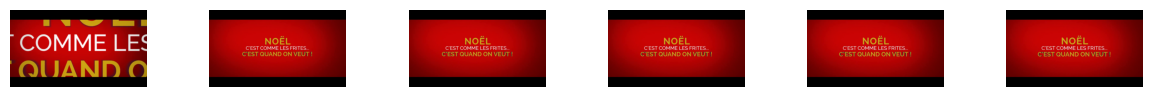

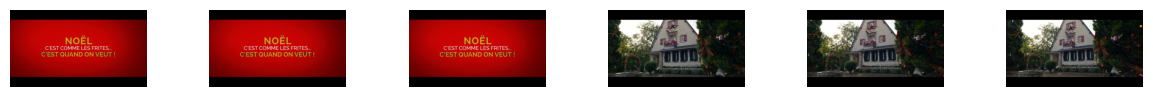

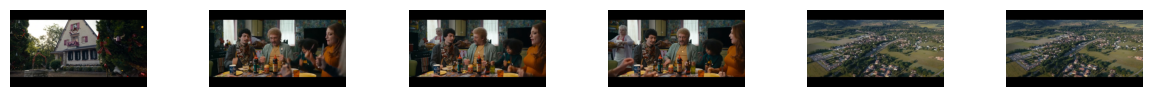

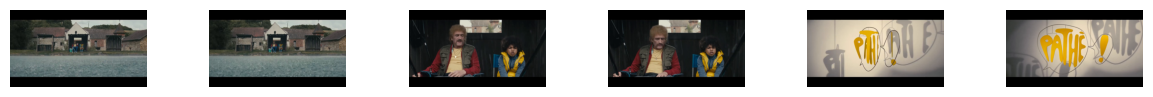

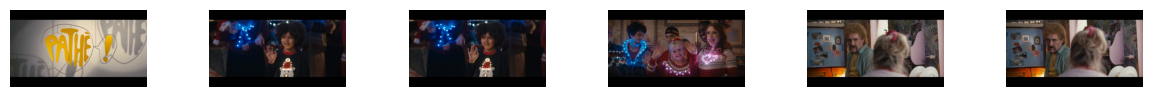

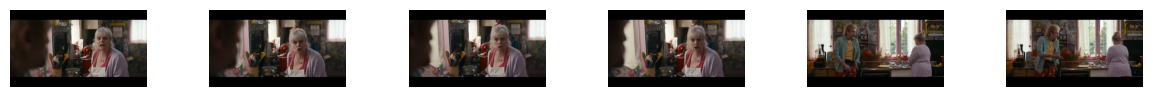

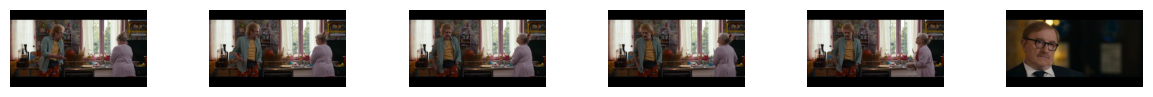

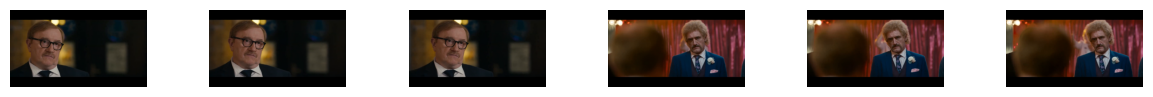

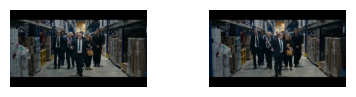

In [158]:
show_frames(lframes)

In [178]:
# Make window

def make_windows(values,window_size = 3):
    assert window_size <= len(values)
    return [values[i:i+window_size] for i in range(len(values) - window_size + 1)]
    
frames_windows = make_windows(lframes,window_size = 32)

In [184]:
# Get all windows embeddings

def make_embeddings(frames):
    assert len(frames) == 32
    inputs = processor(videos=list(frames), return_tensors="pt")
    video_features = model.get_video_features(**inputs)
    return video_features

embeddings = [make_embeddings(x) for x in tqdm(frames_windows)]

  0%|          | 0/19 [00:00<?, ?it/s]

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 60217344 bytes.

# Comparing image embeddings sequentially

In [135]:
video = Video(path = video_path,max_seconds = 30,fps = 2)
frames = [x.array for x in video.frames]

  0%|          | 0/246 [00:00<?, ?it/s]

Stopped after 30 seconds


In [136]:
len(frames)

63

In [137]:
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Downloading:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [15]:
from scipy.spatial import distance_matrix

In [19]:
from sklearn.metrics import pairwise_distances

In [20]:
dm = pairwise_distances(embeddings,metric = "cosine")

In [21]:
import plotly.express as px
fig = px.imshow(dm)
fig.show()

In [32]:
np.median(dm)

0.8048473232570009

### Gender with CLIP

In [140]:
from bechdelai.image.clip import CLIP
from bechdelai.image.gender_detection import GenderDetector

# Scene detection & change detection
- https://www.amazon.science/blog/automatically-identifying-scene-boundaries-in-movies-and-tv-shows
- https://github.com/wanglimin/MRCNN-Scene-Recognition
- https://scenedetect.com/projects/Manual/en/latest/api.html#quickstart
- https://scenedetect.com/projects/Manual/en/latest/api.html#example
- https://paperswithcode.com/task/scene-change-detection

In [125]:
%%time
video = Video(path = video_path,detect_scenes = True)

Detected: 61 | Progress: : 2817frames [00:08, 326.47frames/s]

Detected 62 scenes in the video


  0%|          | 0/62 [00:00<?, ?it/s]

CPU times: total: 41.6 s
Wall time: 14.2 s


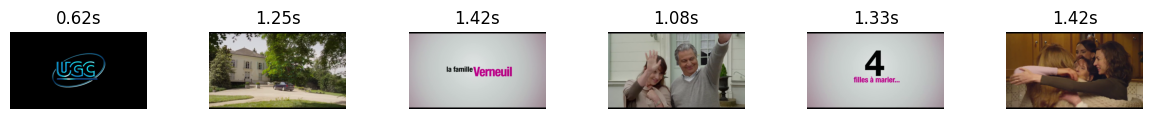

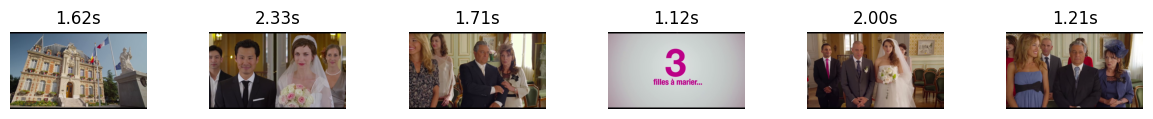

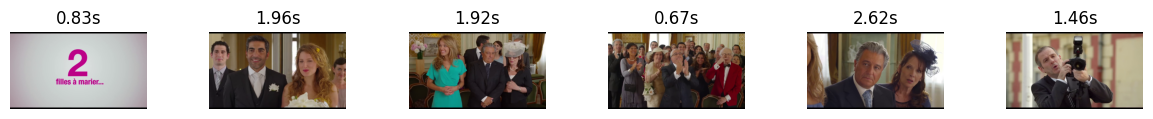

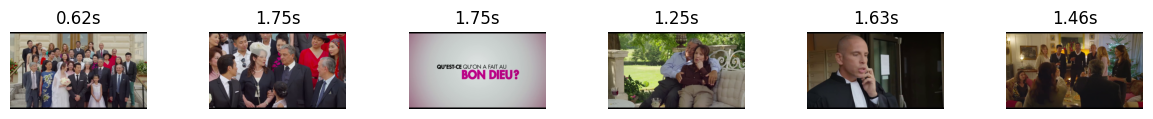

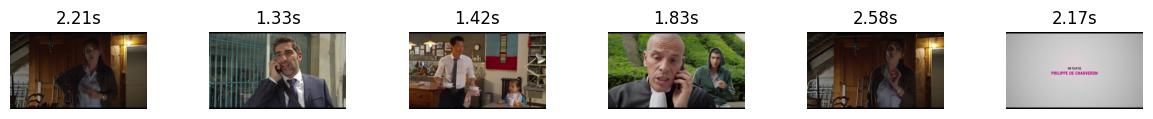

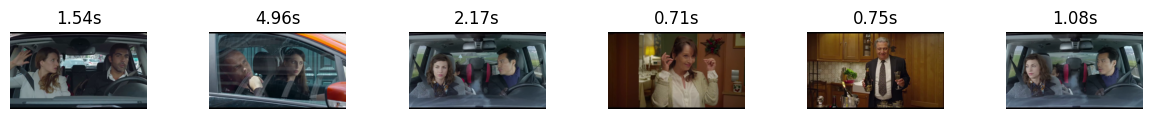

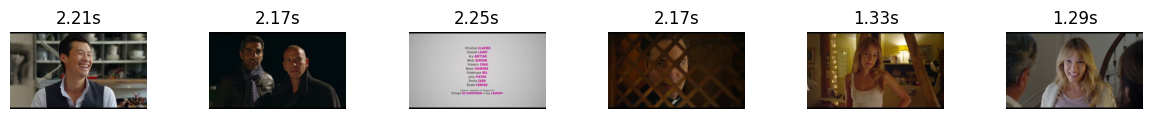

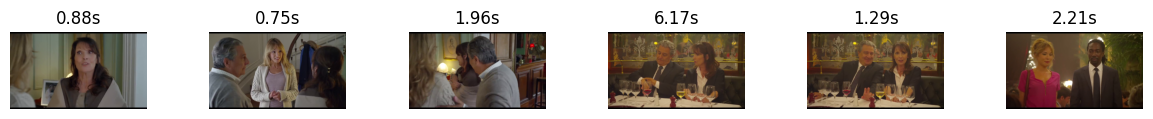

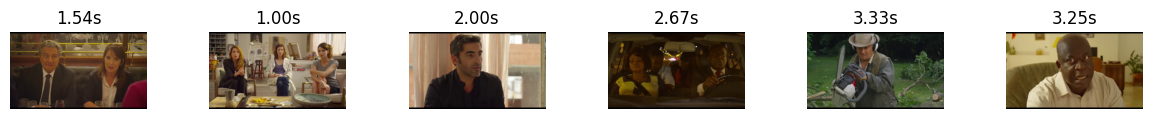

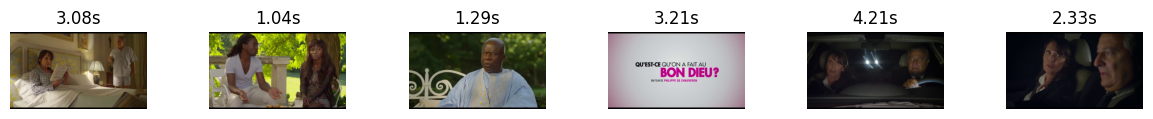

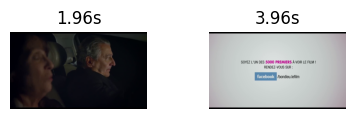

In [126]:
video.show_frames(titles = video.scenes_durations)

# Test whisper
- https://colab.research.google.com/github/openai/whisper/blob/master/notebooks/LibriSpeech.ipynb#scrollTo=_PokfNJtOYNu
- https://github.com/openai/whisper
- https://huggingface.co/spaces/JUNGU/Whisper-Auto-Subtitled-Video-Generator/blob/main/01_%F0%9F%8E%A5_Input_YouTube_Link.py

In [185]:
import whisper

model = whisper.load_model("base")
# result = model.transcribe("audio.mp3")
# print(result["text"])

In [186]:
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is multilingual and has 71,825,920 parameters.


In [188]:
# predict without timestamps for short-form transcription
options = whisper.DecodingOptions(
    task = "transcribe",
    language="fr", 
    without_timestamps=False,
    suppress_blank = False,
)

In [216]:
from moviepy.editor import VideoFileClip


def convert_video_to_audio_moviepy(video_file, output_ext="mp3"):
    """Converts video to audio using MoviePy library
    that uses `ffmpeg` under the hood"""
    filename, ext = os.path.splitext(video_file)
    clip = VideoFileClip(video_file)
    audio_path = f"{filename}.{output_ext}"
    clip.audio.write_audiofile(audio_path)
    return audio_path

In [217]:
audio_path = convert_video_to_audio_moviepy(video_path,"wav")

MoviePy - Writing audio in LES TUCHE 4 Bande Annonce Officielle (2021).wav




chunk:   0%|                                                                        | 0/2600 [00:00<?, ?it/s, now=None]

chunk:  10%|█████▉                                                      | 255/2600 [00:00<00:00, 2513.52it/s, now=None]

chunk:  26%|███████████████▎                                            | 663/2600 [00:00<00:00, 3424.03it/s, now=None]

chunk:  39%|██████████████████████▉                                    | 1013/2600 [00:00<00:00, 3444.18it/s, now=None]

chunk:  52%|██████████████████████████████▉                            | 1361/2600 [00:00<00:00, 3273.66it/s, now=None]

chunk:  65%|██████████████████████████████████████▍                    | 1693/2600 [00:00<00:00, 3118.15it/s, now=None]

chunk:  78%|█████████████████████████████████████████████▋             | 2015/2600 [00:00<00:00, 3140.76it/s, now=None]

chunk:  90%|████████████████████████████████████████████████████▉      | 2332/2600 [00:00<00:00, 3119.06it/s, now=None]

                              

MoviePy - Done.


In [218]:
audio_path

'LES TUCHE 4 Bande Annonce Officielle (2021).wav'

In [220]:
audio_path

'LES TUCHE 4 Bande Annonce Officielle (2021).wav'

In [221]:
!start .

In [228]:
# https://github.com/openai/whisper/discussions/514

In [229]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio(audio_path)


AttributeError: module 'ffmpeg' has no attribute 'Error'

In [ ]:
audio = whisper.pad_or_trim(audio)